# CarND: Behavioral Cloning

In [2]:
import os
import random
import numpy as np
import scipy.signal as scs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from typing import Optional, Tuple

In [3]:
%matplotlib inline
sns.set_style("whitegrid")

In [4]:
MODEL_PATH = 'models'

In [5]:
DATASET_PATH = os.path.join('.', 'dataset')
DATASET_PATH

'./dataset'

In [6]:
DRIVING_LOG_FILENAME = 'driving_log.csv'
DRIVING_LOG_PATH = os.path.join(DATASET_PATH, DRIVING_LOG_FILENAME)
DRIVING_LOG_PATH

'./dataset/driving_log.csv'

In [7]:
df = pd.read_csv(DRIVING_LOG_PATH, header=None, 
                 names=['Center Image', 'Left Image', 'Right Image', 
                        'Steering Angle', 
                        'Throttle', 'Brake', 'Speed'])
df.sample(n=10)

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Brake,Speed
11806,IMG/center_2018_10_10_21_05_37_378.jpg,IMG/left_2018_10_10_21_05_37_378.jpg,IMG/right_2018_10_10_21_05_37_378.jpg,-0.052941,1.000000,0.0,30.190320
5278,IMG/center_2018_10_07_22_30_37_447.jpg,IMG/left_2018_10_07_22_30_37_447.jpg,IMG/right_2018_10_07_22_30_37_447.jpg,-0.288235,0.000000,0.0,14.485100
14993,IMG/center_2018_10_12_20_41_30_938.jpg,IMG/left_2018_10_12_20_41_30_938.jpg,IMG/right_2018_10_12_20_41_30_938.jpg,0.000000,1.000000,0.0,30.189480
14740,IMG/center_2018_10_12_20_40_20_200.jpg,IMG/left_2018_10_12_20_40_20_200.jpg,IMG/right_2018_10_12_20_40_20_200.jpg,0.000000,1.000000,0.0,29.223750
7860,IMG/center_2018_10_07_22_39_27_458.jpg,IMG/left_2018_10_07_22_39_27_458.jpg,IMG/right_2018_10_07_22_39_27_458.jpg,0.429412,0.285795,0.0,11.365510
10641,IMG/center_2018_10_10_21_04_03_398.jpg,IMG/left_2018_10_10_21_04_03_398.jpg,IMG/right_2018_10_10_21_04_03_398.jpg,-0.011765,1.000000,0.0,30.190270
11705,IMG/center_2018_10_10_21_05_29_532.jpg,IMG/left_2018_10_10_21_05_29_532.jpg,IMG/right_2018_10_10_21_05_29_532.jpg,-0.035294,1.000000,0.0,30.190180
7798,IMG/center_2018_10_07_22_39_22_510.jpg,IMG/left_2018_10_07_22_39_22_510.jpg,IMG/right_2018_10_07_22_39_22_510.jpg,-0.182353,0.000000,0.0,13.830190
8469,IMG/center_2018_10_07_22_40_16_120.jpg,IMG/left_2018_10_07_22_40_16_120.jpg,IMG/right_2018_10_07_22_40_16_120.jpg,1.000000,0.000000,0.0,8.298722
2763,IMG/center_2018_10_07_22_22_46_715.jpg,IMG/left_2018_10_07_22_22_46_715.jpg,IMG/right_2018_10_07_22_22_46_715.jpg,0.000000,1.000000,0.0,30.190170


In [8]:
df.dtypes

Center Image       object
Left Image         object
Right Image        object
Steering Angle    float64
Throttle          float64
Brake             float64
Speed             float64
dtype: object

In [9]:
df['Steering Angle'] = df['Steering Angle'].astype(np.float32)
df['Throttle']       = df['Throttle'].astype(np.float32)
df['Brake']          = df['Brake'].astype(np.float32)
df['Speed']          = df['Speed'].astype(np.float32)

Here's an overview of the dataset. We find that we have some 15.7k training examples (for each camera position), resulting in roughly 47k training examples when all images are used. We're going to ignore throttle, brake and speed controls during training, but will still investigate them in order to see if we can harvest some information about the dataset.

In [10]:
df.describe()

,Steering Angle,Throttle,Brake,Speed
count,15679.000000,15679.000000,15679.000000,1.567900e+04
mean,0.013505,0.660368,0.007195,2.269208e+01
std,0.297498,0.444207,0.068826,8.494032e+00
min,-1.000000,0.000000,0.000000,3.321202e-07
25%,-0.047059,0.000000,0.000000,1.443129e+01
50%,0.000000,1.000000,0.000000,3.013469e+01
75%,0.035294,1.000000,0.000000,3.019023e+01
max,1.000000,1.000000,1.000000,3.058793e+01


Let's see how the data is distributed. If, for example, only left turns were made (and no data augmentation is performed), a trained model would very likely be biased towards left turns.

We first define a helper function for plotting the data.

In [9]:
def histogram(series: pd.Series, name: str, label: str, filename: Optional[str]=None, bins: int=100):
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    series.hist(bins=bins, ax=axs[0])
    series.hist(bins=bins, log=10, ax=axs[1])
    f.suptitle('Distribution of {}'.format(name))
    axs[0].set_ylabel('Number of values')
    axs[0].set_xlabel(label)
    axs[1].set_ylabel('Number of values')
    axs[1].set_xlabel(label)
    sns.despine()
    if filename is not None:
        plt.savefig(os.path.join('examples', filename))

When we look at the steering angles, we quickly find that most of the steering angles appear to be exactly or very close to zero. The distribution of angles also seems to be slightly skewed to the left, which we will mitigate by mirroring the images during training. We can also see some minor spikes at both ends of the spectrum indicating that extreme angles were used much more often than moderate ones.

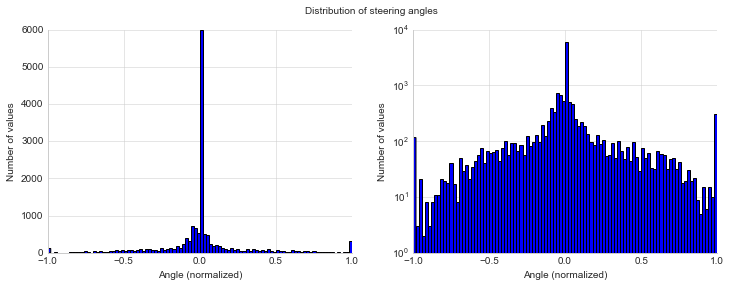

In [10]:
histogram(df['Steering Angle'], 'steering angles', 'Angle (normalized)', 'steering-angles.png')

Here's the number of occurrences and ranges numerically when using 100 bins as above:

In [11]:
counts, ranges = np.histogram(df['Steering Angle'], bins=100)
counts, ranges

(array([ 116,    3,   21,    2,    8,    3,    8,   11,   11,   21,   19,
          18,   41,   17,    8,   50,   29,   37,   21,   34,   45,   57,
          75,   40,   67,   61,   63,   69,   44,   76,  100,   57,   93,
          91,   68,   87,   57,  126,   83,   97,  131,   95,  194,  125,
         234,  398,  329,  719,  673,  534, 5991,  496,  469,  250,  187,
         222,  184,  133,   98,   87,  128,   88,  103,   54,   57,   91,
          49,  102,   68,   47,   78,   44,   96,   52,   29,   74,   50,
          61,   33,   32,   66,   58,   57,   32,   47,   51,   32,   43,
          18,   19,   31,   19,   22,    9,    5,   15,    6,   15,   10,
         305]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
        -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
        -0.28, -0.26, -0.24, -0.22

When we median filter the occurrences, we find that the peak gets replaced with a value of 494.

In [12]:
scs.medfilt(counts)

array([  3.,  21.,   3.,   8.,   3.,   8.,   8.,  11.,  11.,  19.,  19.,
        19.,  18.,  17.,  17.,  29.,  37.,  29.,  34.,  34.,  45.,  57.,
        57.,  67.,  61.,  63.,  63.,  63.,  69.,  76.,  76.,  93.,  91.,
        91.,  87.,  68.,  87.,  83.,  97.,  97.,  97., 131., 125., 194.,
       234., 329., 398., 673., 673., 673., 534., 496., 469., 250., 222.,
       187., 184., 133.,  98.,  98.,  88., 103.,  88.,  57.,  57.,  57.,
        91.,  68.,  68.,  68.,  47.,  78.,  52.,  52.,  52.,  50.,  61.,
        50.,  33.,  33.,  58.,  58.,  57.,  47.,  47.,  47.,  43.,  32.,
        19.,  19.,  19.,  22.,  19.,   9.,   9.,   6.,  15.,  10.,  15.,
        10.])

Given that this is about 10% of the original bin size, we'll be stochastically undersampling the "zero" angles by 90% (i.e. keep only randomly chosen 10% of the data) in order to prevent bias. 

In [13]:
494 / 5205

0.09490874159462055

When we look at the distribution of the absolute angles we find that the amounts appear to be log-linearly decreasing with increasing absolute angle, except for the peak at maximum angle. We could oversample angles with few occurrences, but given that these should be used only in extreme situations anyways, it might make sense to keep the distribution like that.

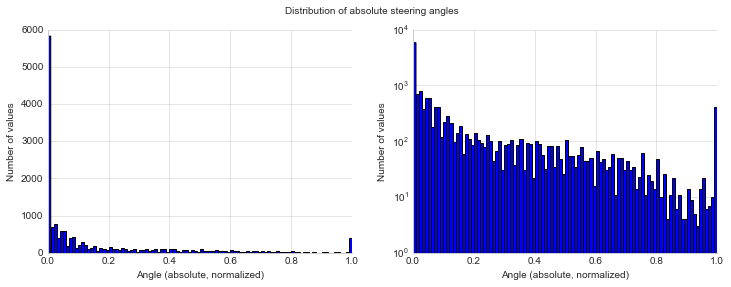

In [14]:
histogram(df['Steering Angle'].abs(), 'absolute steering angles', 'Angle (absolute, normalized)', bins=100)

When we look at the statistics of the absolute steering angles, we find that only 50% of the values are greater than about 0.04. Since the simulator steering angles range from `-25` to `25` (degrees, presumable), this would correspond to an angle of 0.88235 degrees (again, presumably).

In [15]:
df['Steering Angle'].abs().describe()

count    15679.000000
mean         0.162649
std          0.249462
min          0.000000
25%          0.000000
50%          0.041176
75%          0.217647
max          1.000000
Name: Steering Angle, dtype: float64

We see that for the extreme "angle" of `+1` we have more values, resulting in a mean value that is slightly positive, despite the "bump" on the negative side of the distribution.

In [16]:
df['Steering Angle'].describe()

count    15679.000000
mean         0.013505
std          0.297498
min         -1.000000
25%         -0.047059
50%          0.000000
75%          0.035294
max          1.000000
Name: Steering Angle, dtype: float64

As stated already, mirroring the image data during training will duplicate the number of examples and iron out these small issues. Even without that, the dataset appears to be balanced; care needs to be taken not to oversample the "zero" angles. As they make up for more than one third (about 36%) of the training data, this could introduce a severe bias.

In [17]:
sum(df['Steering Angle'] == 0) / len(df['Steering Angle'])

0.3530199630078449

For generating steering angle noise, we can later use the human driver's steering angle standard deviation to generate a gaussian to sample noise from.

In [18]:
steering_std = df['Steering Angle'].std()
steering_std

0.29749835

The throttle values show an entirely different picture: The values are either exactly zero or exactly one, indicating that the car was mostly standing still or driving at full speed during the training data collection. When looking at the log-transformed data, we see that there are indeed some values in between, but they are most likely sampled only during acceleration phases. We might want to undersample examples of zero throttle as we don't want the model to learn how to _not_ move.

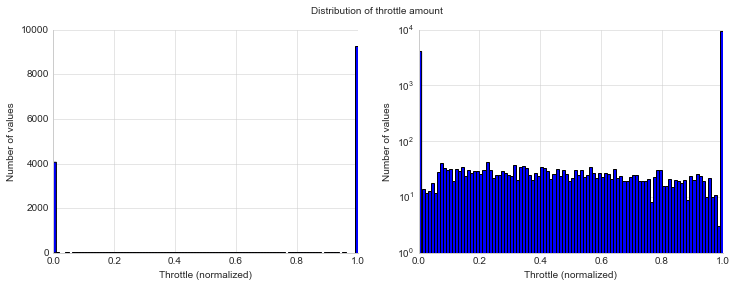

In [19]:
histogram(df['Throttle'], 'throttle amount', 'Throttle (normalized)', 'throttle-values.png')

The brake values appear are mostly zero. This makes sense: We already know the car was moving mostly at full speed, so the brake was only used for a fraction of the time.

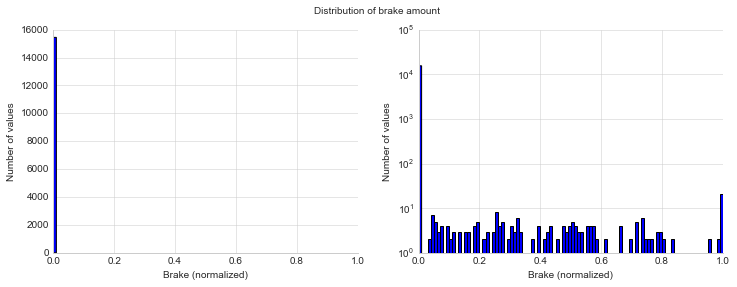

In [20]:
histogram(df['Brake'], 'brake amount', 'Brake (normalized)', 'brake-values.png')

Interestingly for the speeds we find a big amount of data distributed around 15 miles/hour. This might be due to data collection on the optional track: As that one is much harder to maneuver through, lower speeds were used there. The high spike for full speed corresponds to the high spike for full throttle. Zero speed situations are of no use to us.

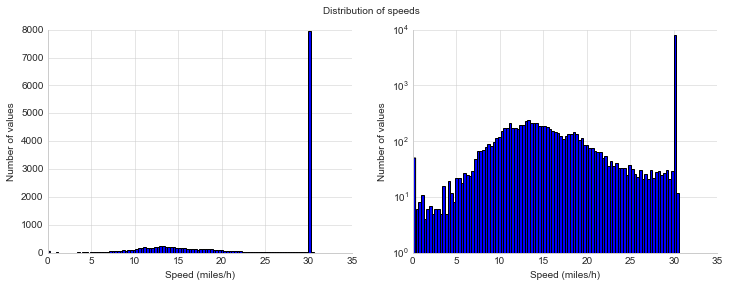

In [21]:
histogram(df['Speed'], 'speeds', 'Speed (miles/h)', 'speed-values.png')

## Sampling training data

We're going to sample data based on zero or nonzero steering angle.

In [22]:
zero_angles = (df['Steering Angle'] == 0)
sum(zero_angles)

5535

As stated before, we're generally only interested in rows with a positive speed.

In [23]:
positive_speed = (df['Speed'] > 0)
sum(positive_speed)

15679

We now split the dataset into two groups: Zero and nonzero steering angles.

In [24]:
sample_seed = 0
df_nonzero_angles = df[positive_speed & ~zero_angles]
df_zero_angles    = df[positive_speed & zero_angles]

We're going to split both sets into two groups once more: Training and validation data.

In [25]:
df_train_nonzero, df_valid_nonzero = train_test_split(df_nonzero_angles, 
                                                      test_size=0.3, random_state=sample_seed)
df_train_zero, df_valid_zero       = train_test_split(df_zero_angles, 
                                                      test_size=0.3, random_state=sample_seed)

We now split the validation set again into the actual validation set (used during training) and a test set (used to validate the final model).

In [26]:
df_test_nonzero, df_valid_nonzero = train_test_split(df_valid_nonzero, 
                                                     test_size=0.3, random_state=sample_seed)
df_test_zero, df_valid_zero       = train_test_split(df_valid_zero, 
                                                     test_size=0.3, random_state=sample_seed)

The "zero" training dataset still has too many elements. We're going to take a random sample of it for training.

In [27]:
zero_speed_factor = 0.1
zero_speed_count_train = int(zero_speed_factor * len(df_train_zero))
zero_speed_count_valid = int(zero_speed_factor * len(df_valid_zero))
zero_speed_count_test  = int(zero_speed_factor * len(df_test_zero))

In [28]:
df_train_zero = df_train_zero.sample(zero_speed_count_train, random_state=sample_seed)
df_valid_zero = df_valid_zero.sample(zero_speed_count_valid, random_state=sample_seed)
df_test_zero  = df_test_zero.sample(zero_speed_count_test, random_state=sample_seed)

Here's the actual size of the "nonzero" training, validation and test sets now:

In [29]:
len(df_train_nonzero), len(df_valid_nonzero), len(df_test_nonzero)

(7100, 914, 2130)

These are the counts of the "zero" sets:

In [30]:
len(df_train_zero), len(df_valid_zero), len(df_test_zero)

(387, 49, 116)

We now combine the data into the actual data sets used for training.

In [31]:
df_train = pd.concat([df_train_zero, df_train_nonzero])
df_valid = pd.concat([df_valid_zero, df_valid_nonzero])
df_test = pd.concat([df_test_zero, df_test_nonzero])
len(df_train), len(df_valid), len(df_test)

(7487, 963, 2246)

For the first iteration of training, we're only going to train with images from the center camera.

In [32]:
import keras

Using TensorFlow backend.


We'll be using a custom data generator as described in [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly).

In [33]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df: pd.DataFrame, batch_size: int=32, dim: Tuple[int, int]=(320, 160, 3), shuffle=True,
                dataset_path: str=DATASET_PATH):
        self.batch_size = batch_size
        self.df = df
        self.dim = dim
        self.shuffle = shuffle
        self.dataset_path = dataset_path
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        rows = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(rows)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            # self.df = self.df.sample(frac=1).reset_index(drop=True)
            self.df = shuffle(self.df)

    def __data_generation(self, rows) -> Tuple[np.ndarray, np.float32]:
        """Generates data containing batch_size samples"""
        # Initialization
        width, height, channels = self.dim
        X = np.empty((self.batch_size, height, width, channels), dtype=np.uint8)
        y = np.empty((self.batch_size), dtype=np.float32)
        
        # Generate data
        for i, (idx, row) in enumerate(rows.iterrows()):
            # Store sample and angle
            X[i,], y[i] = self._get_example(row)

        return X, y
    
    def _get_example(self, row) -> Tuple[np.ndarray, np.float32]:
        path = os.path.join(self.dataset_path, row['Center Image'])
        img = Image.open(path).convert('RGB')
        X = np.array(img).astype(np.uint8)
        y = row['Steering Angle']
        return X, y

Let's test the generator:

In [34]:
test_generator = DataGenerator(df_train, batch_size=2)
print('Number of samples:', len(test_generator))

Number of samples: 3743


Let's enumerate some of the examples:

(2, 160, 320, 3) (2,)


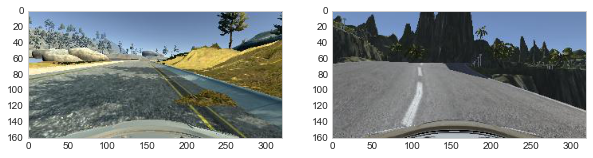

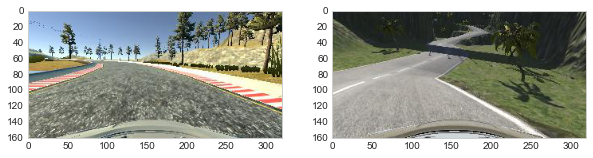

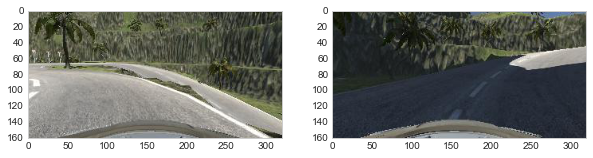

In [35]:
i = 0
for i, (X, y) in enumerate(test_generator):
    if i == 0:
        print(X.shape, y.shape)
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(X[0])
    axs[1].imshow(X[1])
    axs[0].grid(None)
    axs[1].grid(None)
    i += 1
    if i == 3:
        break

Since the sky region is not containing any information relevant to steering, we can remove it. A possible exception to this assumption would be situations where the car is driving down a hill; it might be worth exploring that later.
Likewise, the bottom part of the image always contains the hood of the car and is thus not relevant to steering. If we decide to use images from the left and right camera as well, this region might be problematic as well, as the network could learn to be biased towards the position of the hood.

In [36]:
NVIDIA_WIDTH  = 200
NVIDIA_HEIGHT = 66
NVIDIA_ASPECT = NVIDIA_HEIGHT / NVIDIA_WIDTH

In [37]:
NEW_WIDTH = int(NVIDIA_WIDTH)
NEW_HEIGHT = int(320 * NVIDIA_ASPECT)
print('{}, {}'.format(NEW_WIDTH, NEW_HEIGHT))

200, 105


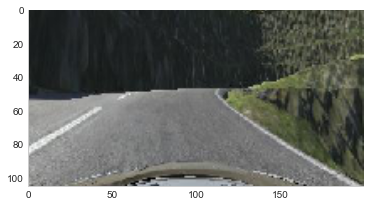

In [38]:
test_img_path = os.path.join(DATASET_PATH, df_train.iloc[1]['Center Image'])
test_img = Image.open(test_img_path).convert('RGB').resize((NEW_WIDTH, NEW_HEIGHT))
test_img = np.array(test_img).astype(np.float32) / 255.
plt.imshow(test_img)
plt.grid(None)
sns.despine()

Cropped image size: (66, 200, 3)


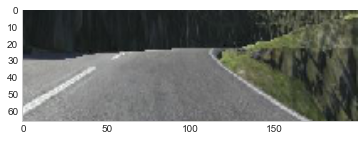

In [39]:
CROP_TOP = 24
CROP_BOTTOM = 15

cropped_test_img = test_img[CROP_TOP:-CROP_BOTTOM, ...]
print('Cropped image size: {}'.format(cropped_test_img.shape))
plt.imshow(cropped_test_img)
plt.grid(None)
sns.despine()

## Building a baseline network architecture

As a baseline, we're going to implement the model suggested by the [End to End Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) published by NVIDIA:

![Network architecture for "End to End Learning for Self-Driving Cars"](examples/nvidia-model.png)

In [40]:
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-3

In [41]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Lambda, Activation, Conv2D, Cropping2D

The paper specifies image input is converted to YUV prior to processing.

In [42]:
def yuv_conversion(x):
    import tensorflow as tf
    x = tf.cast(x, dtype=tf.float32) / 255.0
    return tf.image.rgb_to_yuv(x)

In order to be as close to the original paper as possible, we'll be resizing the image to 200 pixels in width such that after cropping, the input image size will `200x66`.

In [43]:
def image_resize(x):
    return K.tf.image.resize_images(x, (105, 200))

In [51]:
def nvidia_model(learning_rate: float, decay: float=0):    
    model = Sequential()

    # Resizing the images to the NVIDIA proposed shape:
    model.add(Lambda(image_resize, input_shape = (160, 320, 3), name='resize_image'))
    
    # YUV conversion and normalization
    model.add(Lambda(yuv_conversion, input_shape = (105, 200, 3), name='rgb_to_yuv'))
    model.add(Lambda(lambda x: x * 2 - 1, input_shape = (105, 200, 3), name='normalize'))
    
    # Crop the image to remove the sky and car hood
    model.add(Cropping2D(cropping=((CROP_TOP, CROP_BOTTOM), (0, 0)), 
                         input_shape=(105, 200, 3), name='crop'))
    
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', name='conv_1'))
    model.add(Activation('relu', name='conv_1_relu'))
    
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', name='conv_2'))
    model.add(Activation('relu', name='conv_2_relu'))
    
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', name='conv_3'))
    model.add(Activation('relu', name='conv_3_relu'))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', name='conv_4'))
    model.add(Activation('relu', name='conv_4_relu'))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', name='conv_5'))
    model.add(Activation('relu', name='conv_5_relu'))

    model.add(Flatten())    

    model.add(Dense(100, name='fc_1'))
    model.add(Activation('relu', name='fc_1_relu'))
    
    model.add(Dense(50, name='fc_2'))
    model.add(Activation('relu', name='fc_2_relu'))
    
    model.add(Dense(10, name='fc_3'))
    model.add(Activation('relu', name='fc_3_relu'))

    model.add(Dense(1, name='angle'))

    adam = Adam(lr=learning_rate, decay=decay)
    model.compile(optimizer=adam, loss='mse') 
    
    return model

K.clear_session()
model = nvidia_model(LEARNING_RATE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_image (Lambda)        (None, 105, 200, 3)       0         
_________________________________________________________________
rgb_to_yuv (Lambda)          (None, 105, 200, 3)       0         
_________________________________________________________________
normalize (Lambda)           (None, 105, 200, 3)       0         
_________________________________________________________________
crop (Cropping2D)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv_1_relu (Activation)     (None, 31, 98, 24)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 47, 36)        21636     
__________

In this setup, the number of parameters after flattening (`1152`) differs from the NVIDIA paper (`1164`). However, since the paper explicitly states a convolution output of `64@1x18` was obtained, the number reported by NVIDIA appears to be an error.

We can now create the training and validation data generators.

In [45]:
training_generator   = DataGenerator(df_train, batch_size=BATCH_SIZE)
validation_generator = DataGenerator(df_valid, batch_size=BATCH_SIZE)

We'll be using a `ModelCheckpoint` to save a model whenever the validation loss decreases.

An issue exists for Keras 2.2.4 that prevents writing checkpoint files when `ModelCheckpoint` is used with `fit_generator()` and `use_multiprocessing=True` (see [here](https://github.com/keras-team/keras/issues/11101)). One suggested workaround is to use formatted file names, which is what we'll do.

In [46]:
CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'nvidia.{epoch:02d}-{val_loss:.4f}.h5')
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', verbose=1,
                             save_best_only=True, mode='min')

In addition, early stopping will be used to terminate training if the validation loss doesn't improve for multiple epochs.

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                               mode='min', restore_best_weights=False)

We can now run the training.

In [48]:
hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=True, workers=6,
                           callbacks=[checkpoint, early_stopping],
                           epochs=EPOCHS, verbose=1)

Epoch 1/100
58/58 [==============================] - 27s 470ms/step - loss: 0.0888 - val_loss: 0.0610

Epoch 00001: val_loss improved from inf to 0.06097, saving model to models/nvidia.01-0.0610.h5
Epoch 2/100
58/58 [==============================] - 20s 352ms/step - loss: 0.0563 - val_loss: 0.0527

Epoch 00002: val_loss improved from 0.06097 to 0.05267, saving model to models/nvidia.02-0.0527.h5
Epoch 3/100
58/58 [==============================] - 21s 358ms/step - loss: 0.0489 - val_loss: 0.0437

Epoch 00003: val_loss improved from 0.05267 to 0.04374, saving model to models/nvidia.03-0.0437.h5
Epoch 4/100
58/58 [==============================] - 21s 361ms/step - loss: 0.0430 - val_loss: 0.0415

Epoch 00004: val_loss improved from 0.04374 to 0.04148, saving model to models/nvidia.04-0.0415.h5
Epoch 5/100
58/58 [==============================] - 22s 377ms/step - loss: 0.0364 - val_loss: 0.0431

Epoch 00005: val_loss did not improve from 0.04148
Epoch 6/100
57/58 [=======================

When looking at the training and validation losses, we find that both appeared to still decrease at the time training was early stopped. Training loss is still a fair amount from zero and validation loss didn't go up, so overfitting doesn't seem to be an issue yet. We might want to train for more epochs (e.g. using more patience for early stopping) and possibly use a lower learning rate.

In [179]:
def plot_training_history(hist):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.set_title('Training and validation loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('training epoch')
    ax.legend(['training loss', 'validation loss'], loc='upper right')
    sns.despine()

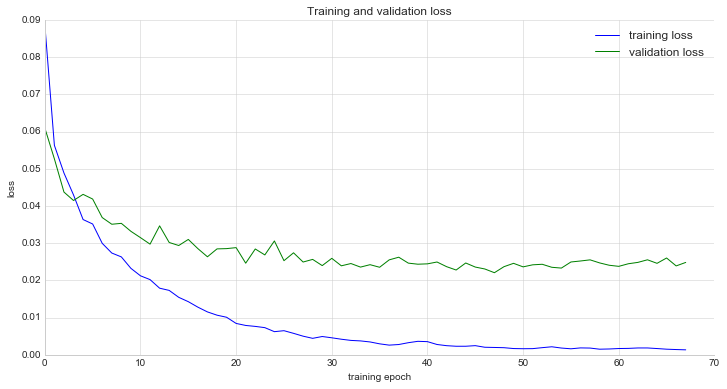

In [50]:
plot_training_history(hist)

In [51]:
def free_gpu_memory():
    K.clear_session()
    cuda.select_device(0)
    cuda.close()
    
# free_gpu_memory()

See [`video/nvidia.48-0.0221.mp4`](video/nvidia.48-0.0221.mp4) for a video of the learned autonomous steering.

## Training data augmentation

Some of the inferred steering angles in the video above are a bit problematic; ignoring the fact that my driving instructions on the simulator weren't too smooth either, we can try adding more data and a somewhat noisy steering angle to force the network to generalize more.

A simple augmentation we can do is randomly flipping the images and inverting the steering angle. Another trick proposed by the NVIDIA paper is to make use of two additional cameras installed to the left and right of the car's center. This basically simulates slightly offset car positions, introducing more training data. If we assume a destination angle as determined by the center camera, due to trigonometry, we need to add correction factor to the angle whenever we're using either the left or right image, positive and negative respectively. Since no reference values for distances are given, we'll be simply using an arbitrarily selected value of e.g. `0.2`. 

![](examples/carnd-using-multiple-cameras.jpg)

To prevent overfitting, a zero-mean gaussian noise is added to the recorded steering angles during training additionally.

In [45]:
class AugmentingDataGenerator(DataGenerator):
    'Generates data for Keras'
    def __init__(self, df: pd.DataFrame, batch_size: int=32, dim: Tuple[int, int]=(320, 160, 3), shuffle=True,
                dataset_path: str=DATASET_PATH, steering_std: float=0, shift_correction: float=0.2):
        super().__init__(df, batch_size, dim, shuffle, dataset_path)
        self.steering_std = steering_std
        self.shift_correction = shift_correction
    
    def _get_example(self, row) -> Tuple[np.ndarray, np.float32]:
        i = random.randint(0, 2)
        r = random.randint(0, 1)
        if i == 0:
            path = os.path.join(self.dataset_path, row['Center Image'])
            correction = 0
        elif i == 1:
            path = os.path.join(self.dataset_path, row['Left Image'])
            correction = +self.shift_correction
        else:
            path = os.path.join(self.dataset_path, row['Right Image'])
            correction = -self.shift_correction
        
        angle = row['Steering Angle'] + correction
        angle += np.random.normal(scale=self.steering_std)
        
        img   = Image.open(path).convert('RGB')
        if r == 1:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            angle = -angle
        X = np.array(img).astype(np.uint8)
        y = angle
        return X, y

With this, we restart the training.

In [48]:
K.clear_session()
model = nvidia_model(LEARNING_RATE)

training_generator   = AugmentingDataGenerator(df_train, batch_size=BATCH_SIZE, 
                                               steering_std=steering_std,
                                               shift_correction=0.2)
validation_generator = DataGenerator(df_valid, batch_size=BATCH_SIZE)

CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'nvidia-aug.{epoch:02d}-{val_loss:.4f}.h5')
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', verbose=1,
                             save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                               mode='min', restore_best_weights=False)

hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=True, workers=6,
                           callbacks=[checkpoint, early_stopping],
                           epochs=EPOCHS, verbose=1)

Epoch 1/100
58/58 [==============================] - 21s 370ms/step - loss: 0.2108 - val_loss: 0.0917

Epoch 00001: val_loss improved from inf to 0.09166, saving model to models/nvidia-aug.01-0.0917.h5
Epoch 2/100
58/58 [==============================] - 19s 336ms/step - loss: 0.1837 - val_loss: 0.0905

Epoch 00002: val_loss improved from 0.09166 to 0.09051, saving model to models/nvidia-aug.02-0.0905.h5
Epoch 3/100
58/58 [==============================] - 19s 333ms/step - loss: 0.1810 - val_loss: 0.0746

Epoch 00003: val_loss improved from 0.09051 to 0.07458, saving model to models/nvidia-aug.03-0.0746.h5
Epoch 4/100
58/58 [==============================] - 19s 329ms/step - loss: 0.1677 - val_loss: 0.0753

Epoch 00004: val_loss did not improve from 0.07458
Epoch 5/100
58/58 [==============================] - 20s 353ms/step - loss: 0.1739 - val_loss: 0.0655

Epoch 00005: val_loss improved from 0.07458 to 0.06546, saving model to models/nvidia-aug.05-0.0655.h5
Epoch 6/100
57/58 [=======

58/58 [==============================] - 20s 349ms/step - loss: 0.1314 - val_loss: 0.0360

Epoch 00041: val_loss did not improve from 0.03443
Epoch 42/100
58/58 [==============================] - 20s 346ms/step - loss: 0.1343 - val_loss: 0.0382

Epoch 00042: val_loss did not improve from 0.03443
Epoch 43/100
58/58 [==============================] - 21s 361ms/step - loss: 0.1266 - val_loss: 0.0385

Epoch 00043: val_loss did not improve from 0.03443
Epoch 44/100
58/58 [==============================] - 21s 359ms/step - loss: 0.1240 - val_loss: 0.0362

Epoch 00044: val_loss did not improve from 0.03443
Epoch 45/100
58/58 [==============================] - 20s 340ms/step - loss: 0.1271 - val_loss: 0.0346

Epoch 00045: val_loss did not improve from 0.03443
Epoch 46/100
58/58 [==============================] - 20s 347ms/step - loss: 0.1295 - val_loss: 0.0361

Epoch 00046: val_loss did not improve from 0.03443
Epoch 47/100
58/58 [==============================] - 20s 339ms/step - loss: 0.1294

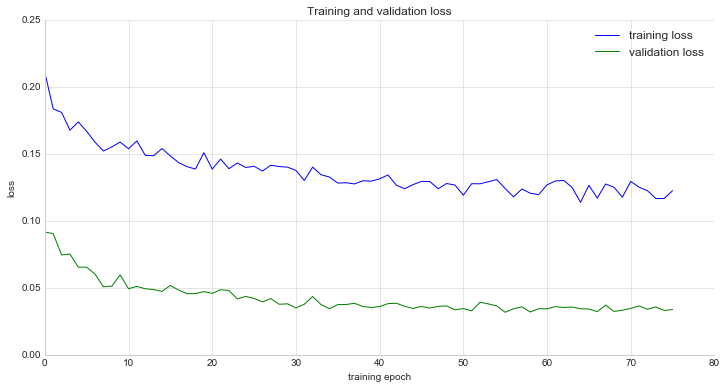

In [49]:
plot_training_history(hist)

Interestingly - due to the noise augmentation - the validation loss is now much lower than the training loss. Even in comparison to the previous experiment the validation loss is now higher; however, a visual inspection of the driving results show that the car is now driving much more in the center of the lane, rather than sticking to the sides.

Here are some videos from autonomous driving mode with network controls:

See [`video/nvidia-aug.56-0.0317.mp4`](video/nvidia-aug.56-0.0317.mp4) for one lap on the training track (bigger version [on YouTube](https://www.youtube.com/watch?v=mL6ASo7dZX0)).

<a href="https://www.youtube.com/watch?v=mL6ASo7dZX0"><img src="examples/nvidia-aug.png" /></a>


Here's [`video/nvidia-aug-2.56-0.0317.mp4`](video/nvidia-aug-2.56-0.0317.mp4) for some turns on the harder track with an unintended stop (bigger version [on YouTube](https://www.youtube.com/watch?v=sxXvtvNnhzQ)).

<a href="https://www.youtube.com/watch?v=sxXvtvNnhzQ"><img src="examples/nvidia-aug-2.png" /></a>

And another slightly longer run on the same track in [`video/nvidia-aug-2_longer.56-0.0317.mp4`](video/nvidia-aug-2_longer.56-0.0317.mp4).

The accuracy on the harder track is suprisingly high, however the network fails to safely maneuver the car all the way. Sampling more data from there would certainly help.

## Alternative network architecture

From the training and validation loss plots, we don't have reason to believe the network has overfit the training data at all. However, the project rubrik requires using additional countermeasures such as dropout or regularization. Since this has to be added anyway, we can directly experiment with different network architectures as well.

We'll also be feeding in the original image size and crop the entire top part.

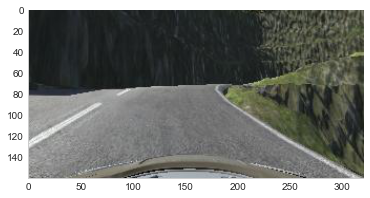

In [150]:
test_img_path = os.path.join(DATASET_PATH, df_train.iloc[1]['Center Image'])
test_img = Image.open(test_img_path).convert('RGB')
test_img = np.array(test_img).astype(np.float32) / 255.
plt.imshow(test_img)
plt.grid(None)
sns.despine()

Cropped image size: (63, 320, 3)


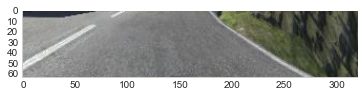

In [151]:
CROP_TOP_BIG = 75
CROP_BOTTOM_BIG = 22

cropped_test_img = test_img[CROP_TOP_BIG:-CROP_BOTTOM_BIG, ...]
print('Cropped image size: {}'.format(cropped_test_img.shape))
plt.imshow(cropped_test_img)
plt.grid(None)
sns.despine()

The core changes we'll be doing to the NVIDIA network are the following:

- The original image size is used, i.e. resizing is removed,
- 2D convolutions are replaced with depthwise separable 2D convolutions,
- ReLU activations are replaced with Parametric ReLU, and
- Dropout is added before the first fully connected layer.

The removal of the resizing step is done purely to improve processing speed; at the same time, the introduction of depthwise separable convolutions should allow for some reduction of parameters as well. Much more importantly, using a depthwise separable convolution in the input layer follows the intuition that grayscale intensity matters much more to lane detection than color. By learning filters individually for the luminance (Y) and chrominance (U and V) channels, it should be possible to focus the training on the more important channels rather than trying to use them simultaneously. Separable convolutions are kept for later layers because of the same reason; a rather efficient class of neural networks designed for mobile use (such as embedded systems) using separable convolutions are [MobileNets](https://arxiv.org/abs/1704.04861).

ReLU activations drop all negative activations, effectively cancelling out their gradient, possibly leading to "dead" neurons during training (when a neuron's gradient is zero, no learning can happen ever again). While this allows for pruning of the network, it possibly throws aways computational capabilities of the architecture. Hence, Parametric ReLU units are used instead: Functioning like Leaky ReLU, a class of activation functions that "leaks" negative activations by using a small coefficient on them, Parametric ReLUs allow for learning the influence of negative activations as well at the cost of one extra trainable parameter per activation function. Nowadays, activation functions such as ELU and SELU have proven to be more efficient in terms of training and inference quality; they do rely on exponential functions though, and since the goal is to have a network that should run as fast as possible on an embedded device, I decided not to use them. 

Lastly, dropout is applied exactly once. Since dropout randomly "drops" connections during training, the network has to learn redundancy. When repeatedly using dropouts in subsequent layers, this only becomes worse. Again, pruning may mitigate this effect by simply removing "identical" neurons. Since this is beyond the scope of this project, one instance of dropout in the network was deemed enough.

In [95]:
from keras.layers import SeparableConv2D, Dropout, PReLU

In [175]:
def custom_model(learning_rate: float, decay: float=0, dropout_rate: float=0.3):    
    model = Sequential()
    
    # YUV conversion and normalization
    model.add(Lambda(yuv_conversion,  input_shape = (160, 320, 3), name='rgb_to_yuv'))
    model.add(Lambda(lambda x: x * 2 - 1, name='normalize'))
    
    # Crop the image to remove the sky and car hood
    model.add(Cropping2D(cropping=((CROP_TOP_BIG, CROP_BOTTOM_BIG), (0, 0)), 
                         name='crop'))
    
    model.add(SeparableConv2D(24, (5, 5), strides=(3, 3), padding='valid', 
                              depth_multiplier=16, name='conv_1'))
    model.add(PReLU(name='conv_1_prelu'))
    
    model.add(SeparableConv2D(36, (5, 5), strides=(3, 3), padding='valid', 
                              depth_multiplier=9, name='conv_2'))
    model.add(PReLU(name='conv_2_prelu'))
    
    model.add(SeparableConv2D(48, (3, 3), strides=(2, 2), padding='valid', 
                              depth_multiplier=6, name='conv_3'))
    model.add(PReLU(name='conv_3_prelu'))
    
    model.add(SeparableConv2D(64, (2, 2), strides=(2, 2), padding='valid', 
                              depth_multiplier=9, name='conv_4'))
    model.add(PReLU(name='conv_4_prelu'))

    model.add(Flatten())    
    model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(100, name='fc_1'))
    model.add(PReLU(name='fc_1_prelu'))
    
    model.add(Dense(50, name='fc_2'))
    model.add(PReLU(name='fc_2_prelu'))
    
    model.add(Dense(10, name='fc_3'))
    model.add(PReLU(name='fc_3_prelu'))

    model.add(Dense(1, name='angle'))

    adam = Adam(lr=learning_rate, decay=decay)
    model.compile(optimizer=adam, loss='mse') 
    
    return model

K.clear_session()
model = custom_model(LEARNING_RATE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rgb_to_yuv (Lambda)          (None, 160, 320, 3)       0         
_________________________________________________________________
normalize (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
crop (Cropping2D)            (None, 63, 320, 3)        0         
_________________________________________________________________
conv_1 (SeparableConv2D)     (None, 20, 106, 24)       2376      
_________________________________________________________________
conv_1_prelu (PReLU)         (None, 20, 106, 24)       50880     
_________________________________________________________________
conv_2 (SeparableConv2D)     (None, 6, 34, 36)         13212     
_________________________________________________________________
conv_2_prelu (PReLU)         (None, 6, 34, 36)         7344      
__________

So far, we use less parameters than the original network, allowing for faster inference.

In addition, we'll be explicitly instantiating the images from the left and right cameras as first-class training examples (as opposed to be before, where they were treated as on-line augmentations).

In [176]:
class AugmentingDataGenerator2(DataGenerator):
    'Generates data for Keras'
    def __init__(self, df: pd.DataFrame, batch_size: int=32, dim: Tuple[int, int]=(320, 160, 3), shuffle=True,
                dataset_path: str=DATASET_PATH, steering_std: float=0, shift_correction: float=0.2):
        
        # Combine the training examples
        df_c = df[['Center Image', 'Steering Angle']].rename(columns={'Center Image': 'Image'})
        df_l = df[['Left Image', 'Steering Angle']].rename(columns={'Left Image': 'Image'})
        df_r = df[['Right Image', 'Steering Angle']].rename(columns={'Right Image': 'Image'})
        df_l['Steering Angle'] += shift_correction
        df_r['Steering Angle'] -= shift_correction
        df = pd.concat([df_c, df_l, df_r], axis=0, sort=False)
        
        super().__init__(df, batch_size, dim, shuffle, dataset_path)
        self.steering_std = steering_std
        self.shift_correction = shift_correction
    
    def _get_example(self, row) -> Tuple[np.ndarray, np.float32]:
        path = os.path.join(self.dataset_path, row['Image'])
        angle = row['Steering Angle']
        angle += np.random.normal(scale=self.steering_std)
        
        img = Image.open(path).convert('RGB')
        if random.choice([True, False]):
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            angle = -angle
        X = np.array(img).astype(np.uint8)
        y = angle
        return X, y

We now run the training again.

In [177]:
K.clear_session()
model = custom_model(LEARNING_RATE)

training_generator   = AugmentingDataGenerator2(df_train, batch_size=BATCH_SIZE, 
                                                steering_std=steering_std / 2,
                                                shift_correction=0.2)
validation_generator = DataGenerator(df_valid, batch_size=BATCH_SIZE)

CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'custom-1.{epoch:02d}-{val_loss:.4f}.h5')
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', verbose=1,
                             save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                               mode='min', restore_best_weights=False)

hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=True, workers=6,
                           callbacks=[checkpoint, early_stopping],
                           epochs=EPOCHS, verbose=1)

Epoch 1/100
175/175 [==============================] - 90s 517ms/step - loss: 0.1416 - val_loss: 0.0740

Epoch 00001: val_loss improved from inf to 0.07402, saving model to models/custom-1.01-0.0740.h5
Epoch 2/100
175/175 [==============================] - 94s 537ms/step - loss: 0.1066 - val_loss: 0.0601

Epoch 00002: val_loss improved from 0.07402 to 0.06011, saving model to models/custom-1.02-0.0601.h5
Epoch 3/100
175/175 [==============================] - 93s 531ms/step - loss: 0.0961 - val_loss: 0.0505

Epoch 00003: val_loss improved from 0.06011 to 0.05048, saving model to models/custom-1.03-0.0505.h5
Epoch 4/100
175/175 [==============================] - 92s 527ms/step - loss: 0.0886 - val_loss: 0.0502

Epoch 00004: val_loss improved from 0.05048 to 0.05017, saving model to models/custom-1.04-0.0502.h5
Epoch 5/100
175/175 [==============================] - 94s 539ms/step - loss: 0.0850 - val_loss: 0.0470

Epoch 00005: val_loss improved from 0.05017 to 0.04700, saving model to mod

175/175 [==============================] - 94s 537ms/step - loss: 0.0474 - val_loss: 0.0285

Epoch 00096: val_loss did not improve from 0.02806
Epoch 97/100
175/175 [==============================] - 94s 537ms/step - loss: 0.0484 - val_loss: 0.0301

Epoch 00097: val_loss did not improve from 0.02806
Epoch 98/100
175/175 [==============================] - 94s 537ms/step - loss: 0.0462 - val_loss: 0.0305

Epoch 00098: val_loss did not improve from 0.02806
Epoch 99/100
175/175 [==============================] - 94s 538ms/step - loss: 0.0465 - val_loss: 0.0304

Epoch 00099: val_loss did not improve from 0.02806
Epoch 100/100
175/175 [==============================] - 94s 537ms/step - loss: 0.0479 - val_loss: 0.0285

Epoch 00100: val_loss did not improve from 0.02806


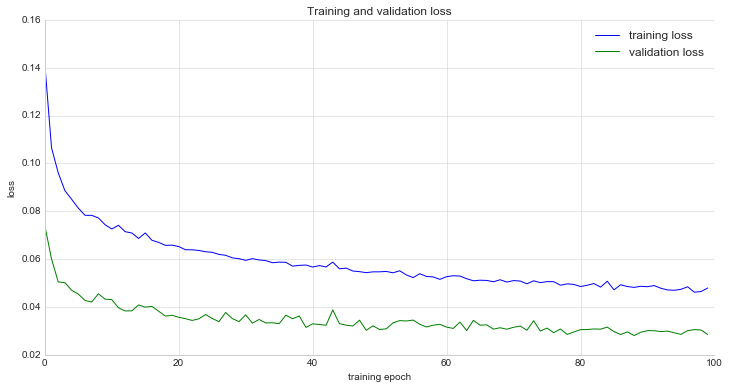

In [180]:
plot_training_history(hist)

We find that the losses are still converging, so the network is far from overfitting. It would likely make sense to continue training, possibly using a smaller learning rate.

Either way, this model made it through the training track with ease and almost mastered the more difficult test track with only one minor incident. The recorded videos can be found at

- [`video/custom-1.89-0.0281.mp4`](video/custom-1.89-0.0281.mp4) for the training track and
- [`video/custom-1-1.89-0.0281.mp4`](video/custom-1-1.89-0.0281.mp4) for the test track.

For the latter, note that the car was braught back to track manually after the incident.

[Here's](https://www.youtube.com/watch?v=w-A2suUnKYw) a video of a the model driving halfway around the test track (running the training track works perfectly but looks somewhat boring at the same time).

<a href="https://www.youtube.com/watch?v=w-A2suUnKYw"><img src="examples/custom-1.png" /></a>

From the driving itself, it seems that the model is steering much more often (and more aggressively at that) than before. One could possibly introduce more "zero angle" examples to help it to learn more about "smooth" driving. When running the model in the simulator problematic situations arise the model doesn't know how to resolve, such as switching lanes, driving dangerously close to the edge of the street and driving straightway into trees, straight toward and eventually off cliffs. Here, it would make sense to gather more training data specifically about those situations. 

Given though that this was actually only done a handful of times during training data collection, the model does remarkably well.